In [1]:
from maze import MazeEnv, ACTIONS
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from IPython import display
import numpy as np
from tqdm import tqdm

In [2]:
width, height = 6, 6
obstacle_positions = [(2, 2), (5, 3), (1, 3), (3,5)]

In [3]:
filename = 'imagedraw.gif'
images = []
env = MazeEnv(width, height, (0,0), obstacle_positions)
state = env.reset()
done = False
reward_sum = 0.0

img = env.render()
im = Image.fromarray(img)
im = im.resize((400, 400), resample=0)
images.append(im)

while not done:
    action = np.random.choice(len(ACTIONS))
    state, reward, done, _ = env.step(action)
    # print(state, reward, done)
    reward_sum += reward
    img = env.render()
    im = Image.fromarray(img)
    im = im.resize((400, 400), resample=0)
    images.append(im)
    
images[0].save(filename,
               save_all=True, append_images=images[1:],
               optimize=False, duration=40, loop=0)
print(reward_sum)

-1117.0


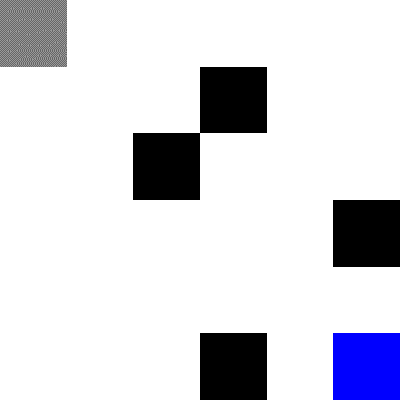

In [4]:
display.Image(filename)

In [5]:
def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def get_episode(env, Q=None):
    episode = []
    state = env.reset()
    done = False
    while not done:
        if Q is None:
            action = np.random.choice(len(ACTIONS))
        else:
           action = np.random.choice(len(ACTIONS), p=get_probs(Q[state], 0.01, len(ACTIONS)))
        new_state, reward, done, _ = env.step(action)
        episode.append((tuple(state), action, reward))
        state = new_state
    return episode

In [6]:
from collections import defaultdict
from pprint import pprint

def approximate_q_function(env, num_episodes = 10000):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for e_id in tqdm(range(num_episodes)):
        episode = get_episode(env)
        states, actions, rewards = zip(*episode)

        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    return Q, N

In [7]:
Q, N = approximate_q_function(env, 10000)

100%|██████████| 10000/10000 [03:19<00:00, 50.12it/s]


In [8]:
env = MazeEnv(width, height, (0,0), obstacle_positions)
episode = get_episode(env, Q)
pprint(episode)

[((0, 0), 2, -1.0),
 ((1, 0), 2, -1.0),
 ((2, 0), 2, -1.0),
 ((3, 0), 0, -1.0),
 ((3, 1), 0, -1.0),
 ((3, 2), 0, -1.0),
 ((3, 3), 2, -1.0),
 ((4, 3), 0, -1.0),
 ((4, 4), 2, -1.0),
 ((5, 4), 0, 20.0)]


In [9]:
def mc_policy(state, eps=0.01):
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    action = policy[state] if np.random.random() > eps else env.action_space.sample()
    return action

def eval_policy(env, policy, num_episodes=100):
    reward_list = []
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        reward_sum = 0.0
        while not done:
            action = policy(state)
            new_state, reward, done, _ = env.step(action)
            # print(state, action, new_state, reward)
            reward_sum += reward
            state = new_state

        reward_list.append(reward_sum)

    avg = np.mean(reward_list)
    print("")
    print("The average cumulative reward {} while {} episodes".format(avg, num_episodes))
    return avg, reward_list

In [10]:
avg, _ = eval_policy(env, lambda s: mc_policy(s, eps=1.0), 1000)

100%|██████████| 1000/1000 [00:31<00:00, 31.82it/s]
The average cumulative reward -507.829 while 1000 episodes



In [11]:
avg, _ = eval_policy(env, mc_policy, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 785.45it/s]
The average cumulative reward 10.784 while 1000 episodes



In [12]:
avg, _ = eval_policy(env, lambda s: mc_policy(s, eps=0.0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 743.89it/s]
The average cumulative reward 11.0 while 1000 episodes



In [13]:
env = MazeEnv(width, height, (0, 0), obstacle_positions)
episode = get_episode(env, Q)
pprint(episode)

[((0, 0), 2, -1.0),
 ((1, 0), 2, -1.0),
 ((2, 0), 2, -1.0),
 ((3, 0), 0, -1.0),
 ((3, 1), 0, -1.0),
 ((3, 2), 0, -1.0),
 ((3, 3), 2, -1.0),
 ((4, 3), 0, -1.0),
 ((4, 4), 2, -1.0),
 ((5, 4), 0, 20.0)]
